# Data Preprocessing

In [1]:
import pandas as pd

df = pd.read_csv("../data/raw/Kaggle-Stroke-Dataset/healthcare-dataset-stroke-data.csv")

display(df.head())


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [2]:
df_processed = df.copy()

In [3]:
display(df_processed.shape)

(5110, 12)

In [4]:
# 
# drop unnecessary columns
# 
# Goal: keep the model simpler for practical use
# 

df_processed.drop(columns=["id"], inplace=True)
df_processed.drop(columns=["avg_glucose_level"], inplace=True) # (most users will not have this information)
df_processed.drop(columns=["Residence_type"], inplace=True) # (showed low predictive value)
df_processed.drop(columns=["ever_married"], inplace=True) # (showed low predictive value)
df_processed.drop(columns=["work_type"], inplace=True) # (showed low predictive value)


In [5]:
# 
# drop rows with missing data and data that may introduce bias
# 

# drop 1 row with "gender" == "Other" as it may introduce bias 
# (in the app, will ask the user for their biological sex)
df_processed = df_processed[df_processed["gender"] != "Other"]


In [6]:
# 
# Handle categorical data (one-hot encoding)
# 

# binary encoding
df_processed['gender'] = df_processed['gender'].map({'Male': 0, 'Female': 1})

# one-hot encoding
df_processed = pd.get_dummies(df_processed, columns=["smoking_status"], prefix="smoking", drop_first=True, dtype=int)

In [7]:
#
# Handle missing values:
# 201 rows with missing values in "bmi" column --> will do median imputation grouped by age bins.
# 


bins = [0, 18, 30, 45, 60, 75, 100]
labels = ['0-17', '18-29', '30-44', '45-59', '60-74', '75+']
df_processed['age_bin'] = pd.cut(df_processed['age'], bins=bins, labels=labels, right=False)

# Compute median BMI per age bin
median_bmi = df_processed.groupby('age_bin', observed=False)['bmi'].median()

print("Median BMI per age bin (ie. values that will be used to impute missing BMI):")
print(median_bmi)


# Impute missing BMI
df_processed['bmi'] = df_processed.apply(
    lambda row: median_bmi[row['age_bin']] if pd.isnull(row['bmi']) else row['bmi'],
    axis=1
)

# Drop age_bin column as it's no longer needed
df_processed.drop(columns='age_bin', inplace=True)

Median BMI per age bin (ie. values that will be used to impute missing BMI):
age_bin
0-17     19.9
18-29    26.2
30-44    29.9
45-59    30.3
60-74    30.0
75+      28.0
Name: bmi, dtype: float64



## Feature engineering

In [8]:
#
# Age binning
#


import numpy as np

bins = [0, 17, 29, 44, 59, 74, np.inf]
labels = ['0-17', '18-29', '30-44', '45-59', '60-74', '75+']

df_processed['age_group'] = pd.cut(df_processed['age'], bins=bins, labels=labels, right=True)
df_processed = pd.get_dummies(df_processed, columns=['age_group'], drop_first=True, dtype=int)


#
# note: for now, keeping column "age" also as a continuous variable
#
#
# df_processed.drop(columns=['age'], inplace=True)
#



In [9]:
#
# Some other options:
#

# x Encode smoking status as ordinal. E.g.: never smoked (0) < unknown (1) < formerly smoked (2) < smokes (3)
#   --> tested, doesn't improve metrics.
# 
# - Feature amplification. E.g. age * (hypertension + heart_disease), to capture interaction effects
#


## Check missing data and data dtypes

In [10]:
#
# Check for any remaining missing values
#

df_processed.isnull().sum() 

gender                     0
age                        0
hypertension               0
heart_disease              0
bmi                        0
stroke                     0
smoking_formerly smoked    0
smoking_never smoked       0
smoking_smokes             0
age_group_18-29            0
age_group_30-44            0
age_group_45-59            0
age_group_60-74            0
age_group_75+              0
dtype: int64

In [11]:
# 
# Check head, dtype, and shape
# 

display(df_processed.dtypes)


gender                       int64
age                        float64
hypertension                 int64
heart_disease                int64
bmi                        float64
stroke                       int64
smoking_formerly smoked      int64
smoking_never smoked         int64
smoking_smokes               int64
age_group_18-29              int64
age_group_30-44              int64
age_group_45-59              int64
age_group_60-74              int64
age_group_75+                int64
dtype: object

In [12]:
display(df_processed.head(10))
print("\n")

display(df_processed.shape)
print("\n")

,gender,age,hypertension,heart_disease,bmi,stroke,smoking_formerly smoked,smoking_never smoked,smoking_smokes,age_group_18-29,age_group_30-44,age_group_45-59,age_group_60-74,age_group_75+
0,0,67.0,0,1,36.6,1,1,0,0,0,0,0,1,0
1,1,61.0,0,0,30.0,1,0,1,0,0,0,0,1,0
2,0,80.0,0,1,32.5,1,0,1,0,0,0,0,0,1
3,1,49.0,0,0,34.4,1,0,0,1,0,0,1,0,0
4,1,79.0,1,0,24.0,1,0,1,0,0,0,0,0,1
5,0,81.0,0,0,29.0,1,1,0,0,0,0,0,0,1
6,0,74.0,1,1,27.4,1,0,1,0,0,0,0,1,0
7,1,69.0,0,0,22.8,1,0,1,0,0,0,0,1,0
8,1,59.0,0,0,30.3,1,0,0,0,0,0,1,0,0
9,1,78.0,0,0,24.2,1,0,0,0,0,0,0,0,1


(5109, 14)

## Train-test split + Feature scaling

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#
# Train-test split
#

X = df_processed.drop(columns=["stroke"])
y = df_processed["stroke"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [14]:
#
# Standardize the features
#


scaler = StandardScaler()

numeric_cols = ["age", "bmi"]

X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [15]:
X_train.head(10)

,gender,age,hypertension,heart_disease,bmi,smoking_formerly smoked,smoking_never smoked,smoking_smokes,age_group_18-29,age_group_30-44,age_group_45-59,age_group_60-74,age_group_75+
845,1,0.209397,0,0,0.545853,0,1,0,0,0,1,0,0
3745,1,-0.629845,0,0,-0.988041,0,1,0,1,0,0,0,0
4184,1,-0.364822,0,0,-0.768913,0,1,0,0,1,0,0,0
3410,0,-0.232310,0,0,0.494293,0,1,0,0,1,0,0,0
284,0,-1.292405,0,0,0.352505,0,0,0,0,0,0,0,0
4797,0,0.209397,0,0,-0.188869,0,1,0,0,0,1,0,0
1283,0,0.871956,1,1,2.015298,1,0,0,0,0,0,1,0
3657,0,-1.734111,0,0,-1.310288,0,0,0,0,0,0,0,0
2485,1,-1.292405,0,0,-0.575565,1,0,0,0,0,0,0,0
1282,0,0.430250,0,1,0.404064,0,0,0,0,0,1,0,0


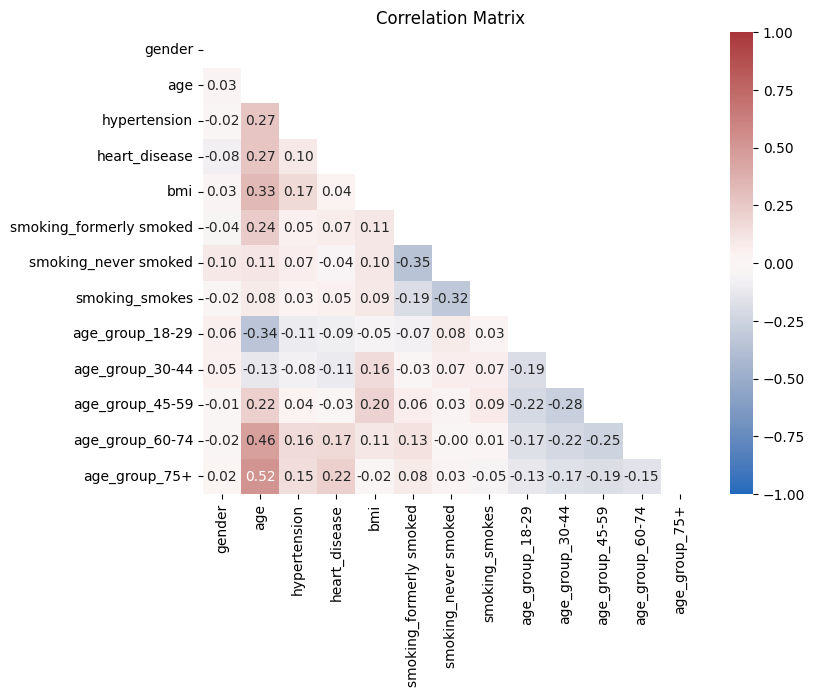

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Correlation matrix
corr_matrix = X_train.corr()

# Plot
plt.figure(figsize=(8, 6))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='vlag', vmin=-1, vmax=1, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()



<br><br>


## Export

In [17]:
import pickle

# processed DataFrame (csv)
df_processed.to_csv("../data/processed/df_processed.csv", index=False)

# train and test sets (pickle)
X_train.to_pickle("../data/processed/X_train.pkl")
X_test.to_pickle("../data/processed/X_test.pkl")
y_train.to_pickle("../data/processed/y_train.pkl")
y_test.to_pickle("../data/processed/y_test.pkl")

# export train and test data also as csv files
X_train.to_csv("../data/processed/X_train.csv", index=False)
X_test.to_csv("../data/processed/X_test.csv", index=False)
y_train.to_csv("../data/processed/y_train.csv", index=False)
y_test.to_csv("../data/processed/y_test.csv", index=False)

# scaler (pickle)
with open("../models/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)


print("Data processing complete:")
print("- Processed data saved to ../data/processed/df_processed.csv")
print("- Train/test sets saved as pickle files.")
print("\n")

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


Data processing complete:
- Processed data saved to ../data/processed/df_processed.csv
- Train/test sets saved as pickle files.


X_train shape: (4087, 13)
X_test shape: (1022, 13)
y_train shape: (4087,)
y_test shape: (1022,)
